<a href="https://colab.research.google.com/github/pkscanvas/Optimal-Satellite-Pose-Estimation-/blob/master/Copy_of_Copy_of_Speedv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mounting the Google Drive to access the dataset.**

In [0]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Importing all necessary packages.


*   The **preprocess_input** function is meant to adequate your image to the format the model requires
*  **ImageDataGenerator:** Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches).



In [0]:

dataset_root="/content/gdrive/My Drive/Colab Notebooks/speed"
import pandas as pd
import os
import json
import numpy as np
import keras
import tensorflow
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.applications.xception import preprocess_input  
from keras.models import Model
from keras.layers import Dense,Flatten,BatchNormalization,Activation,AlphaDropout
from sklearn.model_selection import train_test_split

  



1.   **with:** there is no need to call file.close() when using with statement. The with statement itself ensures proper acquisition and release of resource, it also takes care of all the exceptions by itself
2.   **os.path** contains functions for manipulating filenames and directory names.
3.**os.path.join()** function will add an extra slash to the pathname before joining it to the filename.



In [0]:
with open(os.path.join(dataset_root,'train.json'),'r') as train:
  train_json=json.load(train)
train_json[0]['q_vbs2tango']
#len(train_json)
type(train_json)
# q=train_json[i]['q_vbs2tango']
# r=train_json[i]['r_Vo2To_vbs_true']
# a=q.extend(r)


list

In [0]:
imgname_list=[]
for i in range(len(train_json)):
  imgname_list.append(train_json[i]['filename'])

#imgname_list

Putting all the images and corresponding 7 continuous values (4 from quaternion vector, 3 from position vector) in a Pandas dataframe to be able to use with **flow_from_dataframe** function
for multilabel regression.

In [0]:
label_list=[]
q1,q2,q3,q4,r1,r2,r3=[],[],[],[],[],[],[]
for i in range(len(train_json)):
  q1.append(train_json[i]['q_vbs2tango'][0])
  q2.append(train_json[i]['q_vbs2tango'][1])
  q3.append(train_json[i]['q_vbs2tango'][2])
  q4.append(train_json[i]['q_vbs2tango'][3])
  r1.append(train_json[i]['r_Vo2To_vbs_true'][0])
  r2.append(train_json[i]['r_Vo2To_vbs_true'][1])
  r3.append(train_json[i]['r_Vo2To_vbs_true'][2])
  #q.extend(r)
  #label_list.append(q)



In [0]:
col_dict={'image_names':imgname_list,'q1':q1,'q2':q2,'q3':q3,'q4':q4,'r1':r1,'r2':r2,'r3':r3}
df=pd.DataFrame(col_dict)
#df['labels']=label_list
df_train,df_test=train_test_split(df,test_size=0.2)
len(df_test)
df_train.head()

Previously, one should have to write a custom generator if they have to perform regression or predict multiple columns and utilize the image augmentation capabilities of the ImageDataGenerator, now we can have the target values as just another column/s (must be numerical datatype) in our dataframe, simply provide the column names to the **flow_from_dataframe** and we can now use all the augmentations provided by the ImageDataGenerator

In [0]:
path="/content/gdrive/My Drive/Colab Notebooks/speed/images/train"
cols=['q1','q2','q3','q4','r1','r2','r3']
datagen=ImageDataGenerator(preprocessing_function=preprocess_input,zoom_range=0.2,brightness_range=[0.8,1.2]) #Values less than 1.0 darken the image, e.g. [0.5, 1.0], whereas values larger than 1.0 brighten the image, e.g. [1.0, 1.5], where 1.0 has no effect on brightness.
datagen2=ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator=datagen.flow_from_dataframe(df_train,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(299,299),batch_size=32,color_mode='rgb')
validation_generator=datagen2.flow_from_dataframe(df_test,directory=path,x_col='image_names',y_col=cols,class_mode='other',target_size=(299,299),batch_size=32,color_mode='rgb')


In [0]:
len(train_generator)

**Building our model using Transfer Learning.**

In [0]:

#tensorflow.keras.backend.set_learning_phase(0)
model_pretrained=Xception(weights='imagenet',include_top=False,input_shape=(299,299,3))
#tensorflow.keras.backend.set_learning_phase(1)

#using keras functional api to build our model

x=model_pretrained.output

#x=Flatten()(x)

#x=Dense(32,activation='selu',kernel_initializer='lecun_normal')(x)
        
#x=BatchNormalization()(x)

x=Dense(512,activation='elu',kernel_initializer='he_normal')(x) #
   
#x=AlphaDropout(0.1)(x)
        
# x=Dense(64,activation='selu',kernel_initializer='lecun_normal')(x) #
   
# x=AlphaDropout(0.1)(x)

#x=BatchNormalization()(x)
        
#x=Dense(128,activation='selu',kernel_initializer='lecun_normal')(x)
        
x=Flatten()(x)
        
x=Dense(7,activation='linear')(x)

model=Model(inputs=model_pretrained.input,outputs=x)


# step_size_train=train_generator.n//train_generator.batch_size #It should typically be equal to the number of samples of your dataset divided by the batch size.
# step_size_valid=validation_generator.n//validation_generator.batch_size
# history=model.fit_generator(train_generator,steps_per_epoch=step_size_train,epochs=2,validation_data=validation_generator,validation_steps=step_size_valid)


**IMP** Which layers to train or not should be done before model compilation.

In [0]:
# train_generator[0][0][0][0][0]
# train_generator

In [0]:
for i,j in enumerate(model.layers):
  print(i,':',j)
for layer in model.layers[:17]:
  layer.trainable=True
for layer in model.layers[17:]:
  layer.trainable=True

In [0]:
model.summary()

In [0]:

sgd=keras.optimizers.sgd(lr=1e-3,decay=0, momentum=0.9, nesterov=True)
adam=keras.optimizers.adam(lr=1e-3)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=1e-20,mode='min',verbose=1)
early_stopping=keras.callbacks.EarlyStopping(monitor='val_loss',patience=5,verbose=1,mode='min',min_delta=0.01,restore_best_weights=True)
model.compile(optimizer=adam,loss='mean_squared_error') #,metrics=['mse']
step_size_train=train_generator.n//train_generator.batch_size #It should typically be equal to the number of samples of your dataset divided by the batch size.
step_size_valid=validation_generator.n//validation_generator.batch_size
history=model.fit_generator(train_generator,steps_per_epoch=step_size_train,epochs=50,validation_data=validation_generator,validation_steps=step_size_valid,callbacks=[reduce_lr]) #,early_stopping


In [0]:

for e,v in enumerate(history.history['val_loss']):
  print("Epoch ",e,":",v)

Epoch  0 : 1.8563402223587036
Epoch  1 : 0.5814175848166148
Epoch  2 : 0.5854243016242981
Epoch  3 : 1.3972849249839783
Epoch  4 : 0.5843948904673258
Epoch  5 : 0.39702599167823793
Epoch  6 : 0.3186376744508743
Epoch  7 : 0.3412351727485657
Epoch  8 : 0.3250936098893483
Epoch  9 : 0.3429074364900589
Epoch  10 : 0.3596832213799159
Epoch  11 : 0.3477966129779816
Epoch  12 : 0.3110671037435532
Epoch  13 : 0.34113820413748425
Epoch  14 : 0.29659178654352825
Epoch  15 : 0.3261910027265549
Epoch  16 : 0.32947644909222923
Epoch  17 : 0.30716048419475556
Epoch  18 : 0.31829468508561454
Epoch  19 : 0.3118597435951233
Epoch  20 : 0.31129716416200004
Epoch  21 : 0.3089953891436259
Epoch  22 : 0.30766829252243044
Epoch  23 : 0.30799841503302255
Epoch  24 : 0.3080869122346242
Epoch  25 : 0.30959687848885853
Epoch  26 : 0.3076077095667521
Epoch  27 : 0.30686045746008556
Epoch  28 : 0.3069929172595342
Epoch  29 : 0.30866892337799073
Epoch  30 : 0.3106473763783773
Epoch  31 : 0.30929792563120523
Epoch

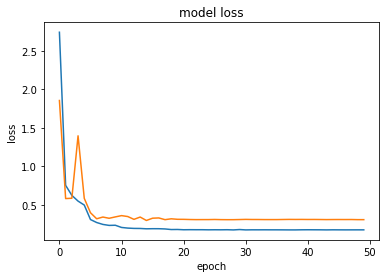

In [0]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [0]:
#Evaluating the model
test_result=[]
q_est,r_est=[],[]
with open(os.path.join(dataset_root,'real.json'),'r') as f_eval:
  test_list=json.load(f_eval)

for img in test_list:
  img_path=os.path.join(dataset_root,'images','real',img['filename'])
  img_arr=image.load_img(img_path,target_size=(299,299))
  x=image.img_to_array(img_arr)
  x=preprocess_input(x)
  x=np.expand_dims(x,axis=0)
  output=model.predict(x)
  output=output.tolist()
  test_result.append({'filename':img['filename'],'q':output[:4],'r':output[4:]})
  q_est.append(output[0][:4])
  r_est.append(output[0][4:])
  print(output)


[[0.06348899006843567, 0.06687120348215103, 0.13640759885311127, 0.03139131888747215, 0.10568525642156601, 0.11914920061826706, 3.251842737197876]]
[[0.059174854308366776, -0.02354532666504383, 0.057957861572504044, 0.018545297905802727, -0.07661950588226318, 0.005956687498837709, 3.2915780544281006]]
[[0.04756024852395058, 0.03099094144999981, 0.04384845867753029, -0.018188100308179855, -0.15903426706790924, 0.0008900674292817712, 4.8843255043029785]]
[[0.0011834509205073118, -0.02057334966957569, 0.02484503760933876, 0.01572663150727749, -0.05504092574119568, -0.009950249455869198, 4.693317890167236]]
[[0.07476510107517242, 0.07751984149217606, -0.04094855114817619, -0.02761460468173027, -0.16005922853946686, -0.13956931233406067, 4.939939975738525]]


In [0]:
# img_path=os.path.join(dataset_root,'images','test','img000014.jpg')
# img_arr=image.load_img(img_path,target_size=(299,299))
# x=image.img_to_array(img_arr)
# x=preprocess_input(x)
# x=np.expand_dims(x,axis=0)
# output=model.predict(x)
# output=output.tolist()
# output

**Extracting r_gt and q_gt from real.json**

In [0]:
real_json=[]
q_gt,r_gt=[],[]
with open(os.path.join(dataset_root,'real.json'),'r') as f:
  real_json=json.load(f)
for i in range(len(real_json)):
  q_gt.append(real_json[i]['q_vbs2tango'])
  r_gt.append(real_json[i]['r_Vo2To_vbs_true'])


**Calculating Orientation Score.**

Orientation score is the angle of the rotation, that aligns the estimated and ground truth orientations:

score(i)orientation=2⋅arccos(∣∣⟨q(i)est,q(i)gt⟩∣∣)

In [0]:
import math
score_orientation=0
bra_ket=[]
for i in range(len(real_json)):
  bra_ket.append(q_est[i][0]*q_gt[i][0]+q_est[i][1]*q_gt[i][1]+q_est[i][2]*q_gt[i][2]+q_est[i][3]*q_gt[i][3])
  
  
for i in range(len(real_json)):
  if bra_ket[i]<1:
    score_orientation+=2*math.acos(bra_ket[i])
score_orientation
#bra_ket



15.574424121993307

**Calculating Position Score**

The position score for image i is simply the 2-norm of the position error (difference of estimated and ground truth position vectors), normalized with the ground truth distance of the satellite:

score(i)position=∣∣r(i)gt−r(i)est∣∣2∣∣r(i)gt∣∣2

In [0]:
from numpy import linalg
score_position=0
for i in range(len(real_json)):
   score_position+=(abs(linalg.norm([r_gt[i]],2)-linalg.norm([r_est[i]],2))/linalg.norm([r_gt[i]],2))

#linalg.norm([r_gt[0]])
score_position

0.4496227202585083

**Finally, the total score is the average of pose scores over all images of the test set:**

In [0]:
score=(score_orientation+score_position)/len(real_json)
score

3.2048093684503627